# Lab 7.8.2: Clustering - Education
STG (The degree of study time for goal object materials)<p>
SCG (The degree of repetition number of user for goal object materials)<p>
STR (The degree of study time of user for related objects with goal object)<p>
LPR (The exam performance of user for related objects with goal object)<p>
PEG (The exam performance of user for goal objects)<p>
UNS (The knowledge level of user)<p>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
df = pd.read_excel('Lab 7.8.2-Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls', sheet_name=1, engine='xlrd')
df = df.iloc[:, :-3]
print(df.columns)
display(df.head(222))

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', ' UNS'], dtype='object')


,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.000,0.00,0.00,0.00,very_low
1,0.08,0.080,0.10,0.24,0.90,High
2,0.06,0.060,0.05,0.25,0.33,Low
3,0.10,0.100,0.15,0.65,0.30,Middle
4,0.08,0.080,0.08,0.98,0.24,Low
...,...,...,...,...,...,...
217,0.60,0.310,0.31,0.87,0.58,High
218,0.51,0.255,0.55,0.17,0.64,Middle
219,0.58,0.295,0.62,0.28,0.30,Low
220,0.61,0.258,0.56,0.62,0.24,Low


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     258 non-null    float64
 1   SCG     258 non-null    float64
 2   STR     258 non-null    float64
 3   LPR     258 non-null    float64
 4   PEG     258 non-null    float64
 5    UNS    258 non-null    object 
dtypes: float64(5), object(1)
memory usage: 12.2+ KB


In [5]:
# Example: convert 'knowlege' column to ordered int values
df.columns = ['study_time', 'repeat_num', 'study_time_usr', 'exam_perf_related', 'exam_perf_goal', 'knowledge']
knowledge_map = {'very_low': 0, 'Low': 1, 'Middle': 2, 'High': 3}
df['knowledge_int'] = df['knowledge'].map(knowledge_map)
display(df)

,study_time,repeat_num,study_time_usr,exam_perf_related,exam_perf_goal,knowledge,knowledge_int
0,0.00,0.00,0.00,0.00,0.00,very_low,0
1,0.08,0.08,0.10,0.24,0.90,High,3
2,0.06,0.06,0.05,0.25,0.33,Low,1
3,0.10,0.10,0.15,0.65,0.30,Middle,2
4,0.08,0.08,0.08,0.98,0.24,Low,1
...,...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,High,3
254,0.78,0.61,0.71,0.19,0.60,Middle,2
255,0.54,0.82,0.71,0.29,0.77,High,3
256,0.50,0.75,0.81,0.61,0.26,Middle,2



=== EM Analysis for 'knowledge_int' ===


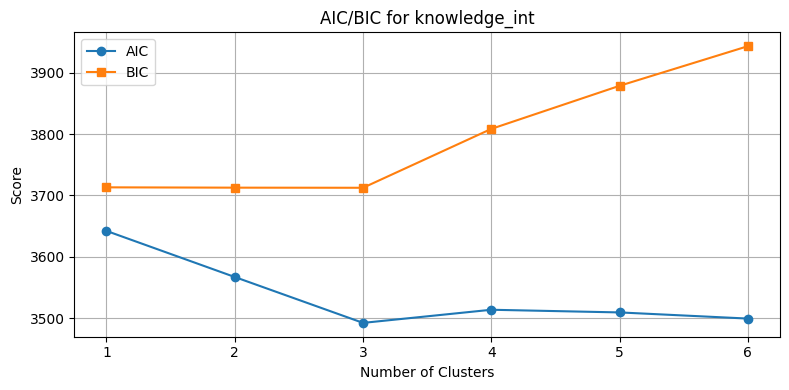

Best model for 'knowledge_int' → 3 clusters (BIC=3712.39)


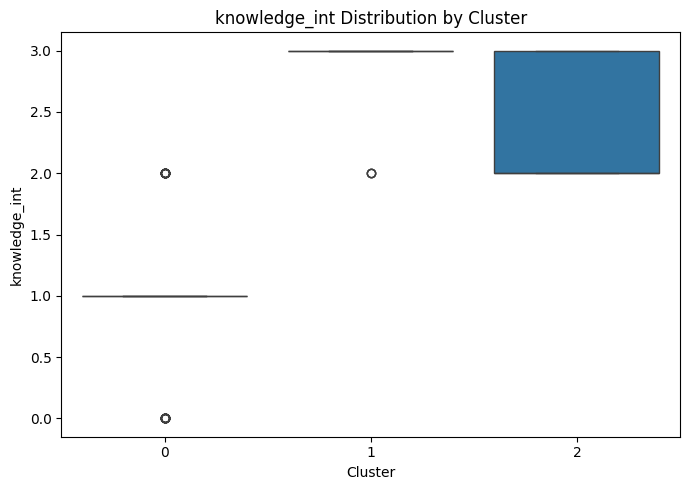


Mean target value per cluster:
Cluster
0    0.95
1    2.90
2    2.35
Name: knowledge_int, dtype: float64


In [8]:
def evaluate_gmm_models(X, max_clusters=6):
    aics, bics = [], []
    models = []

    for k in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        models.append(gmm)

    return aics, bics, models

def apply_em_with_model_selection(df, target_column, max_clusters=6):
    print(f"\n=== EM Analysis for '{target_column}' ===")

    features = df.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    aics, bics, models = evaluate_gmm_models(X_scaled, max_clusters)

    # Plot AIC and BIC
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_clusters + 1), aics, label='AIC', marker='o')
    plt.plot(range(1, max_clusters + 1), bics, label='BIC', marker='s')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'AIC/BIC for {target_column}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Select best model (based on BIC)
    best_n = np.argmin(bics) + 1
    best_gmm = models[best_n - 1]
    best_bic = bics[best_n - 1]
    print(f"Best model for '{target_column}' → {best_n} clusters (BIC={best_bic:.2f})")

    # Assign clusters and plot outcome
    labels = best_gmm.predict(X_scaled)
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels

    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df_with_clusters, x='Cluster', y=target_column)
    plt.title(f'{target_column} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.tight_layout()
    plt.show()

    print("\nMean target value per cluster:")
    print(df_with_clusters.groupby('Cluster')[target_column].mean().round(2))
    return X_scaled, best_bic

# Run analysis for each target
df_temp = df.drop(columns=['knowledge'])
X_scaled, bic = apply_em_with_model_selection(df_temp, 'knowledge_int')


=== EM Analysis for 'knowledge_int' ===


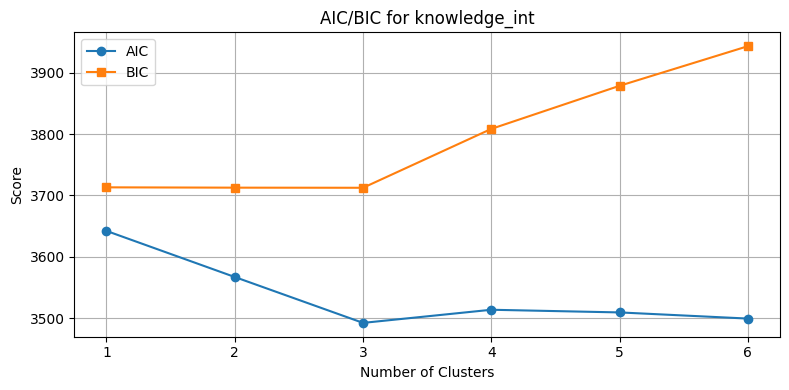

Best model for 'knowledge_int' → 3 clusters (BIC=3712.39)


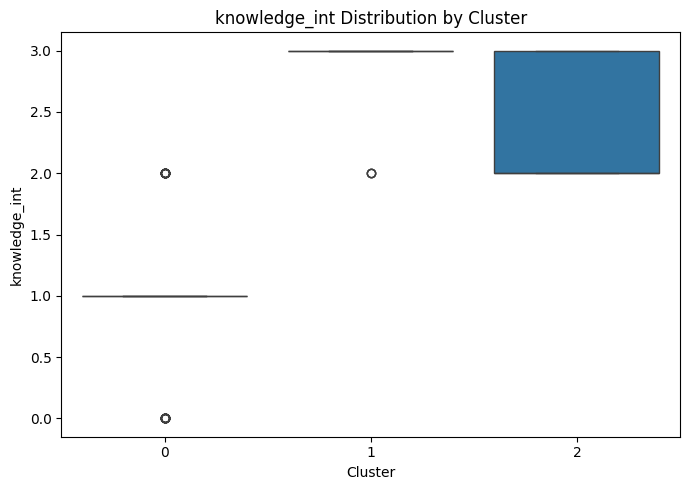


Mean target value per cluster:
Cluster
0    0.95
1    2.90
2    2.35
Name: knowledge_int, dtype: float64

=== Classification Accuracy ===
EM (GMM):    0.686
KMeans:      0.535


In [11]:
def cluster_accuracy(y_true, y_pred):
    # Match cluster labels to true labels using Hungarian Algorithm
    D = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-D)
    accuracy = D[row_ind, col_ind].sum() / y_true.size
    return accuracy

def compare_clustering_accuracy(X_scaled, y_true, best_gmm, best_k=3):
    # GMM predictions
    em_labels = best_gmm.predict(X_scaled)
    em_acc = cluster_accuracy(y_true, em_labels)
    
    # KMeans predictions
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    kmeans_acc = cluster_accuracy(y_true, kmeans_labels)
    
    print(f"\n=== Classification Accuracy ===")
    print(f"EM (GMM):    {em_acc:.3f}")
    print(f"KMeans:      {kmeans_acc:.3f}")
# Run EM
X_scaled, bic = apply_em_with_model_selection(df_temp, 'knowledge_int')

# Evaluate cluster accuracy
y_true = df['knowledge_int'].to_numpy()
best_gmm = GaussianMixture(n_components=3, random_state=42).fit(X_scaled)  # Use best_n if tracked
compare_clustering_accuracy(X_scaled, y_true, best_gmm, best_k=3)
